# South African Language Identification Hack 2022

© Explore Data Science Academy

---
### Honour Code

I {**Raphael Ogechi**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

&ensp;
   ### Hackathon Overview: South African Language Identification Hack 2022
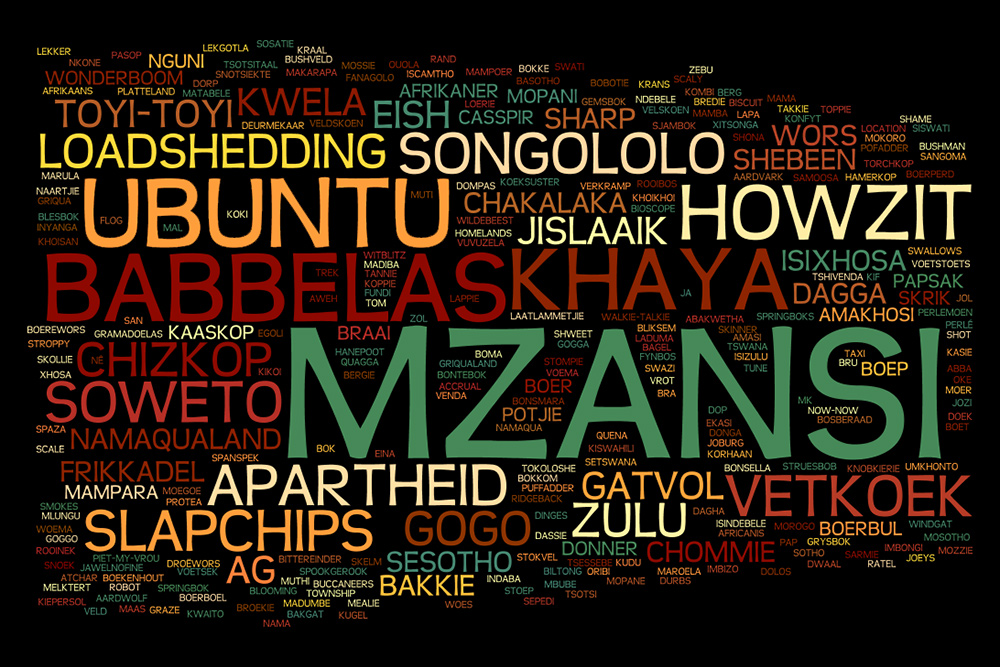





South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society. The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

<a id="cont"></a>

## Table of contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Cleaning</a>

<a href=#five>5. Engineering Features</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#nine>8. References</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


In [348]:
# data loading dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import pickle


# libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# importing libraries for utility from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier


# importing libraries for modelling form sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# libraries to check model metrics from sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Enable interactive visualisations in Jupyter
from ipywidgets import interact, interact_manual, widgets
import plotly.express as px

#word cloud visualization
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### DATASET DESCRIPTION
The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

### LANGUAGE IDs

* afr - Afrikaans
* eng - English
* nbl - isiNdebele
* nso - Sepedi
* sot - Sesotho
* ssw - siSwati
* tsn - Setswana
* tso - Xitsonga
* ven - Tshivenda
* xho - isiXhosa
* zul - isiZulu

In [234]:
#loading dataset
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

#inspect first five rows of train and test set
display(train.head())
display(test.head())

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


### DATASET INFORMATION

In [256]:
def data_info(data):
    '''
    This function basically helps to get basic information about the data set
    It should give information on the number of rows, columns, data points and tell us which
    features are numerical or categorical
    '''
    print('1) Number of columns are: ',data.shape[1])
    print('2) Number of rows are: ',data.shape[0])
    print('3) Total number of data-points:',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features:',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features:',len(cat_features))

In [262]:
print('The train data has the following information:')
data_info(train)

The train data has the following information:
1) Number of columns are:  2
2) Number of rows are:  33000
3) Total number of data-points: 66000
4) Count of Numerical Features: 0
5) Count of Categorical Features: 2


The information above reveals the data is 100% textual in nature

### CHECKING FOR MISSING VALUES

In [259]:
def check_features_with_missing_values(data):
    '''
    This function helps to check features in our data set that has missing value. The basic
    functionality is to provide more context into the following:
    1. Overall calculation of missing values in the data set
    2. Breakdown of features with missing values, the total missing value and the percentage of
       missing values in that column.
    '''
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Overall Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        col_miss = round(data[i].isnull().sum()/len(data[i]) * 100, 2)
        if data[i].isna().sum() > 0:
            print('The Feature',i,'has a total of '+ str(data[i].isna().sum()) + ' missing values which translates to ' +
                 str(col_miss) + '% of values missing in that column')

In [263]:
print('Missing value breakdown: ')
check_features_with_missing_values(train)

Missing value breakdown: 
Percentage of Overall Missing Values is  0.0 %
Missing Value Estimation :


Our dataset contains no missing value. Hence, possess some level of cleanliness. Other data cleaning techniques will be explored in the next section.

### CHECKING FOR CLASS BALANCE

In [328]:
def class_distribution(data, class_variable):
    data[class_variable].value_counts().plot(kind = 'bar', figsize =(12,5))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

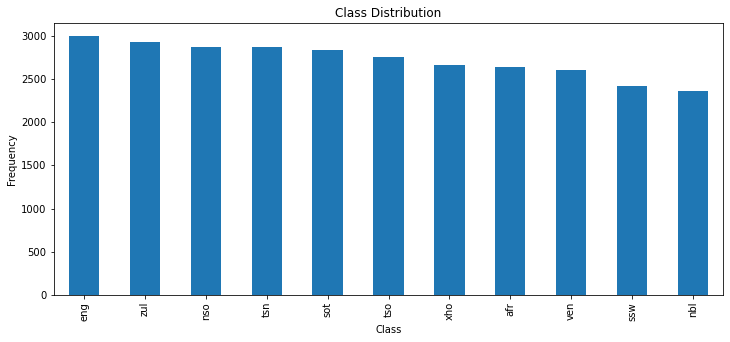

In [329]:
class_distribution(train, 'lang_id')

From the graph above, the bars representing all data set class are at the same level. this is an indication thet the classes are balanced

### CHECKING FOR DUPLICATES

In [294]:
def check_duplicates(data, column_name):
    """
    This function takes in the data frame and the target column for checking duplicates and returns the
    number of duplicates if detected.
    """
    duplicates = pd.DataFrame(data[column_name].duplicated())
    num_of_duplicates = len(duplicates[duplicates[column_name] == True])
    if num_of_duplicates > 0:
        print("Duplicates detected. We have {} number of duplicate value in the dataset".format(num_of_duplicates))
    else:
        print("No duplicates. All good")

In [295]:
check_duplicates(train,'text')

Duplicates detected. We have 3069 number of duplicate value in the dataset


It is of utmost importance we deal with duplicate values. Our dataset shows the presence of some duplicate values. This will be dealt with in the data cleaning section. While dealing with these duplicates, I would have to monitor its effect on the class balance.

## WORD CLOUD

To check the popularity of words used in  each language, word cloud will be employed. This is helpful to understand the tone/usage of words for each language in the corpus

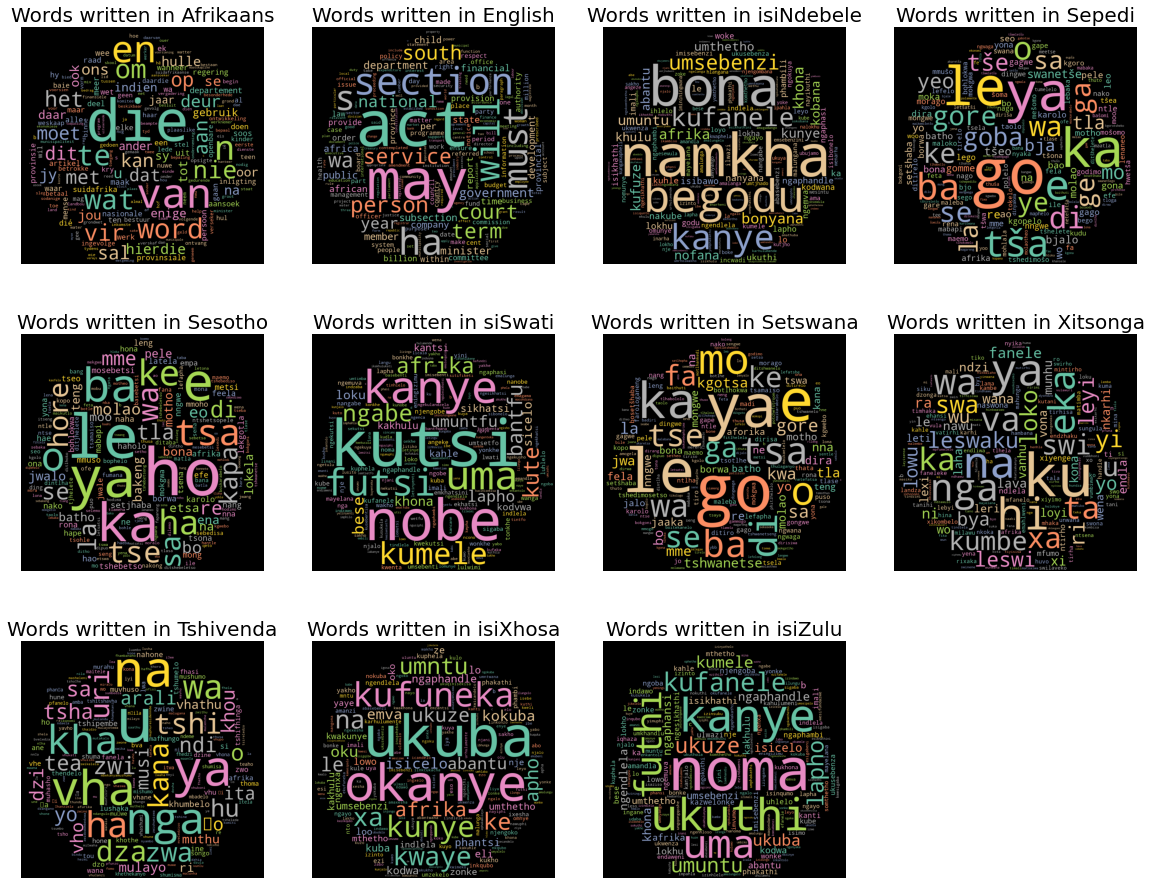

In [305]:
# Generate wordcloud
# initialize news, pro, neutral and anti messages
lang_id = ['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

afr = train[train['lang_id'] == 'afr']['text']
eng = train[train['lang_id'] == 'eng']['text']
nbl = train[train['lang_id'] == 'nbl']['text']
nso = train[train['lang_id'] == 'nso']['text']
sot = train[train['lang_id'] == 'sot']['text']
ssw = train[train['lang_id'] == 'ssw']['text']
tsn = train[train['lang_id'] == 'tsn']['text']
tso = train[train['lang_id'] == 'tso']['text']
ven = train[train['lang_id'] == 'ven']['text']
xho = train[train['lang_id'] == 'xho']['text']
zul = train[train['lang_id'] == 'zul']['text']


afr = [word for line in afr for word in line.split()]
eng = [word for line in eng for word in line.split()]
nbl = [word for line in nbl for word in line.split()]
nso = [word for line in nso for word in line.split()]
sot = [word for line in sot for word in line.split()]
ssw = [word for line in ssw for word in line.split()]
tsn = [word for line in tsn for word in line.split()]
tso = [word for line in tso for word in line.split()]
ven = [word for line in ven for word in line.split()]
xho = [word for line in xho for word in line.split()]
zul = [word for line in zul for word in line.split()]

    
# Define a function to plot word cloud
def plot_cloud(afr, eng, nbl, nso, sot, ssw, tsn, tso, ven, xho, zul):
    # Import image to np.array
    #mask = np.array(Image.open('comment.png'))
    mask1 = np.array(Image.open('polygon.png'))
    
    afr = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(afr))
    
    eng = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(eng))
    
    nbl = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(nbl))
    
    nso = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(nso))
    
    sot = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(sot))
    
    ssw = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(ssw))
    
    tsn = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(tsn))
    
    tso = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(tso))
    
    ven = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(ven))
    
    xho = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(xho))
    
    zul = WordCloud(random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS, mask=mask1).generate(' '.join(zul))

    
    # Set figure size
    plt.figure(figsize = (20,16))
    plt.subplot(3,4,1)
    plt.title('Words written in Afrikaans', fontsize = 20)
    # Display image
    plt.imshow(afr) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,2)
    plt.title('Words written in English', fontsize = 20)
    # Display image
    plt.imshow(eng) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,3)
    plt.title('Words written in isiNdebele', fontsize = 20)
    # Display image
    plt.imshow(nbl) 
    # No axis details
    plt.axis("off")

    plt.subplot(3,4,4)
    plt.title('Words written in Sepedi', fontsize = 20)
    # Display image
    plt.imshow(nso) 
    # No axis details
    plt.axis("off")
  
    plt.subplot(3,4,5)
    plt.title('Words written in Sesotho', fontsize = 20)
    # Display image
    plt.imshow(sot) 
    # No axis details
    plt.axis("off")
        
    plt.subplot(3,4,6)
    plt.title('Words written in siSwati', fontsize = 20)
    # Display image
    plt.imshow(ssw) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,7)
    plt.title('Words written in Setswana', fontsize = 20)
    # Display image
    plt.imshow(tsn) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,8)
    plt.title('Words written in Xitsonga', fontsize = 20)
    # Display image
    plt.imshow(tso) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,9)
    plt.title('Words written in Tshivenda', fontsize = 20)
    # Display image
    plt.imshow(ven) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,10)
    plt.title('Words written in isiXhosa', fontsize = 20)
    # Display image
    plt.imshow(xho) 
    # No axis details
    plt.axis("off")
    
    plt.subplot(3,4,11)
    plt.title('Words written in isiZulu', fontsize = 20)
    # Display image
    plt.imshow(zul) 
    # No axis details
    plt.axis("off")
    

plot_cloud(afr, eng, nbl, nso, sot, ssw, tsn, tso, ven, xho, zul)

From the word clouds above, the words that appear the biggest appears to have the highest frequency for that category while the reverse case happens for the smallest word. For example, the word cloud for words written in English shows that `act`, `section` and `may ` seemed to occur more times in the corpus data. The word usage for this group indicates that the texts centered around politics, government or law

<a id="four"></a>
## 4. Data cleaning and Wrangling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Dealing with duplicates

In the previous section where the detection of duplicates was carried out, it was found out that there are presence of duplicates in the train set, we will have to handle them and monitor the effect of this action on the data class

In [316]:
def remove_duplicates(data):
    """
    This function takes in the dataframe and drops duplicates then return data with dropped duplicates.
    """
    print("Shape before dropping duplicates: {} ".format(data.shape))
    data = data.drop_duplicates()
    print('Shape after dropping duplicates: {}'.format(data.shape))
    return data

In [321]:
train = remove_duplicates(train)

Shape before dropping duplicates: (33000, 2) 
Shape after dropping duplicates: (29931, 2)


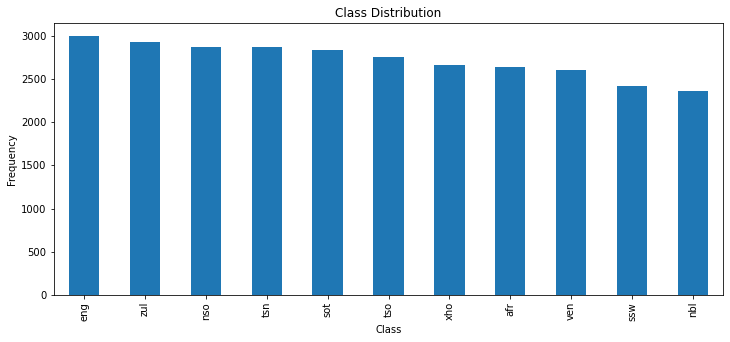

In [330]:
#Checking the effect of dropping duplicates on dataset class
class_distribution(train,'lang_id')

From the visual above, dropping duplicates did not have a drastic effect on the class distribution. We can see that each class have almost equal representation of class. Training a model with this dataset might not lead to the algoruthm being biased favouring the majority class.

The class distribution shows that `English` has the highest representation in the dataset while ` isiNdebele` has the least representation.

### 4.1 Remove punctuations and digits characters <a id="four"></a>
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [187]:
#import string library to form basis for punctuations
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [227]:
def remove_punctuation(text):
    """Takes in a text and removes punctuations"""
    return ''.join([l for l in text if l not in string.punctuation])

In [228]:
def remove_digit(text):
    """Takes in a text and removes number characters"""
    return ''.join([i for i in text if not i.isdigit()])

In [235]:
#applying remove_punctuation and remove_digit function on dataset
train['text'] = train['text'].apply(remove_punctuation,remove_digit)

### 4.2  Tokenization and Lemmatization

For further data cleaning and wrangling, the tokenization and lemmatization methods were employed.

Tokenization is the process of breaking down a phrase, sentence, paragraph, or even an entire text document into simpler components, like individual words or phrases. Tokens are the name for each of these smaller components. Tokens are considered as a first step for stemming and lemmatization (1).

Lemmatization, also known as lemmatization, is a widely used technique in natural language processing that involves grouping together a word's inflected forms so they may be analyzed as a single entity and distinguished by the word's lemma, or dictionary form. Lemmatization aims to condense a word's inflectional and occasionally derived forms to a basic form that is shared by all of them (2).

In [236]:
def token_lem (text):
    """Takes in a text and performs the tokenization and lemmatization NLP technique
    and returns the transformed text"""
    
    
    tokens = word_tokenize(text)

    
    # define lemmatiser
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
   

    return ' '.join([x for x in lem])

In [237]:
#applying tokenization and lemmatization function on dataset
train['text'] = train['text'].apply(token_lem)

<a id="five"></a>
## 5. Engineering Features
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

When it comes to orchestrating the flow of data into and output from a machine learning model, a machine learning pipeline comes in handy. It is known as an end-to-end structure that orchestrates the flow of data into and output from a machine learning model is known as a machine learning pipeline (or set of multiple models). It covers the input of the raw data, the features, the outputs, the machine learning model and model parameters, and the outputs of the predictions.

Here, a machine learning pipeline is employed to easy feature extraction from our text data. The pipeline executes the following steps in chronological order to extract these features and make predictions. They include:

* Count Vectorization: The CountVectorizer tool in Scikit-learn is used to turn a group of text documents into a vector of term/token counts. Additionally, it enables text data to be pre-processed before being turned into a vector form. Its capabilities turn it into a very versatile feature representation module for text(4).


* TF-ID Transformer: With TF-ID transformer, a count matrix is transformed into a normalised tf or tf-idf representation. To reduce the impact of tokens that appear often in a corpus, tf-idf is used in place of the raw frequencies of occurrence of a token in a specific document (5)


* Model: This represents the adopted Machine Learning model

In [332]:
#Instializing the pipeline
pipe = Pipeline([(
    'vect', CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', logit)])


<a id="six"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Having sorted feature extraction, the next thing to do is modelling. We will consider different Machine Learning algorithms for classification tasks. They include:

* Logistics Regression
* Naive Bayes (Multinomial Model)
* Random Forest Classifier

### DATA PREPARATION FOR MODELLING

#### TEST DATA PREPARATION

To ensure uniformity of the test set with the train set, it is important it goes through the same data transformation the 
training set went through. Here, that purpose is achieve

In [334]:
# removing punctuations and digits from test set
test['text'] = test['text'].apply(remove_punctuation, remove_digit)

In [335]:
#apply tokenization and lemmatization on test set
test['text'] = test['text'].apply(token_lem)

#### SPLITING DATASETS INTO TRAIN AND VALIDATION SET

In [336]:
#Defining features and target
X = train['text']
y = train['lang_id']

In [344]:
# splitting into train and validating with sklearn.train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=45)

In [343]:
y_train.shape

(23944,)

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test):
    #building pipeline
    pipe = Pipeline([(
    'vect', CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', model)])
    
    #training model
    pipe.fit(X_train,y_train)
    
    #getting predictions
    prediction = pipe.predict(X_test)
    
    #classification report
    print(classification_report(y_test,prediction))

### LOGISTICS REGRESSION

Logistics regression is a predictive analytics model that is used to describe data and explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.Sometimes, it can also be applied to a dependent variable that is multi-classed (ie have more than 2 variables). The model was adopted because it is a classification algorithm and suited our use case as well.

In [349]:
#Initializing the model
logit = LogisticRegression(random_state=42,multi_class='ovr',n_jobs=1, C=1e5,max_iter=4000)

In [390]:
#training process
train_model(logit, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       0.99      1.00      1.00       610
         nbl       0.99      0.97      0.98       455
         nso       1.00      1.00      1.00       585
         sot       1.00      0.99      1.00       576
         ssw       1.00      0.98      0.99       465
         tsn       1.00      1.00      1.00       607
         tso       1.00      1.00      1.00       523
         ven       1.00      1.00      1.00       486
         xho       0.98      1.00      0.99       541
         zul       0.97      0.97      0.97       620

    accuracy                           0.99      5987
   macro avg       0.99      0.99      0.99      5987
weighted avg       0.99      0.99      0.99      5987

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       0.99      1.00      1.00       610
         nbl       0.99 

## LINEAR SUPPORT VECTOR CLASSIFIER

A linear model for classification and regression issues is the SVM, or Support Vector Machine. It works well for many real-world issues and can solve both linear and non-linear problems. The SVM concept is straightforward: A line or a hyperplane that divides the data into classes is produced by the algorithm<sup>7</sup>.

In this section, I shall implement the linearSVC.

In [416]:
svc = SVC()

In [417]:
train_model(svc, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       1.00      1.00      1.00       610
         nbl       1.00      1.00      1.00       455
         nso       1.00      1.00      1.00       585
         sot       1.00      1.00      1.00       576
         ssw       1.00      1.00      1.00       465
         tsn       1.00      1.00      1.00       607
         tso       1.00      1.00      1.00       523
         ven       1.00      1.00      1.00       486
         xho       1.00      1.00      1.00       541
         zul       1.00      1.00      1.00       620

    accuracy                           1.00      5987
   macro avg       1.00      1.00      1.00      5987
weighted avg       1.00      1.00      1.00      5987

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       1.00      1.00      1.00       610
         nbl       1.00 

### NAIVE BAYES (MULTINOMIALNB)

Mostly employed in Natural Language Processing, the Multinomial Naive Bayes algorithm is a probabilistic learning technique (NLP). The method, which guesses the tag of a text such as an email or newspaper article, is based on the Bayes theorem. For a given sample, it determines the probabilities of each tag, and then outputs the tag with the highest probability.

The Naive Bayes classifier is a collection of many methods, all of which are based on the idea that each feature being classified is independent of every other feature. The existence or absence of one feature has no bearing on the other feature's existence or absence<sup>6</sup>.

In [353]:
naive = MultinomialNB()

In [389]:
train_model(naive, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       1.00      1.00      1.00       610
         nbl       1.00      0.98      0.99       455
         nso       1.00      1.00      1.00       585
         sot       1.00      1.00      1.00       576
         ssw       1.00      0.99      0.99       465
         tsn       1.00      1.00      1.00       607
         tso       1.00      1.00      1.00       523
         ven       1.00      1.00      1.00       486
         xho       1.00      1.00      1.00       541
         zul       0.99      1.00      0.99       620

    accuracy                           1.00      5987
   macro avg       1.00      1.00      1.00      5987
weighted avg       1.00      1.00      1.00      5987

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       519
         eng       1.00      1.00      1.00       610
         nbl       1.00 

<a id="seven"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Let's talk about how accurate the models are. According to the aforementioned categorization study, the models with the best accuracy of 1.0 are the Linear SVC and Naive Bayes models. This indicates that the model did remarkably well on the train data, but it is evident that there is some degree of overfitting because the models, especially for Linear SVC, fared poorly when given unseen data.

Despite having a train accuracy score of 0.99, the Logistic Regression classifier outperformed the Linear SVC model on unseen data, as evidenced by the test accuracy values of both models.

Overall, the Multinomial Naive Bayes model outperformed the competition and will be taken into consideration when the model for language classification is fully trained and developed.

## SUBMISSION TO KAGGLE

In [418]:
# Preparing train and test data for Kaggle submission
X_train_full = train['text']
y_train_full = train['lang_id']
X_test_full = test['text']

In [419]:
kaggle_pipe = Pipeline([('vect',CountVectorizer(stop_words='english',
                                         min_df=2,
                                         max_df=0.9,
                                         ngram_range=(3,6),analyzer=('char'))),
                 ('tfidf',TfidfTransformer()),
                 ('model',logit)])

In [420]:
kaggle_pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char', max_df=0.9, min_df=2,
                                 ngram_range=(3, 6), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [422]:
y_pred_kaggle = pipe_submit.predict(X_test_full)

In [ ]:
# Submission to Kaggle
submit = test.index + 1
Final_Table = {'index': submit, 'lang_id': y_pred}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['index', 'lang_id']]

# Saving submission as CSV file
submission.to_csv('submission_logit.csv', index=False)

<a id="nine"></a>
## 8. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

* 1. https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/
* 2. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
* 3. https://c3.ai/glossary/machine-learning/machine-learning-pipeline/#:~:text=A%20machine%20learning%20pipeline%20is,model%20parameters%2C%20and%20prediction%20outputs.
* 4. https://www.educative.io/answers/countvectorizer-in-python
* 5. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
* 6. https://www.upgrad.com/blog/multinomial-naive-bayes-explained/#:~:text=What%20is%20the%20Multinomial%20Naive,of%20email%20or%20newspaper%20article.
* 7. https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989